#**1. Veri Seti Seçimi**

Projede incelenmek üzere **netflix customer churn** veri seti seçilmiştir. Bu veri seti modelleme için uygun olması nedeniyle seçilmiştir.

 Modellemede  bulunması gereken train, validation ve test veri setleri ise netflix_customer_churn.csv ham verisinin ilk olarak train(%80) - test(%20) olarak 2'ye, daha sonra da train'in yeniden train(%80) - validation(%20) olarak 2'ye bölünmesiyle oluşturulmuştur. Bölme işlemi vscode ortamında python ile yapılmıştır.

*stratify=ncc["churned"] ifadesiyle veri setinin orantılı bölünmesi amaçlanmıştır. Bu sayede 3 veri setinde de churned sınıfları benzer dağılımda olur.*

train - test bölünmesi:
```
import pandas as pd
from sklearn.model_selection import train_test_split

ncc = pd.read_csv("netflix_customer_churn.csv")

train_df, test_df = train_test_split(ncc, test_size=0.2, random_state=42, stratify=ncc["churned"])

train_df.to_csv("ncc_train.csv", index=False)
test_df.to_csv("ncc_test.csv", index=False)
```
new_train - validation bölünmesi:
```
new_train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["churned"])

new_train_df.to_csv("ncc_new_train.csv", index=False)
val_df.to_csv("ncc_validation.csv", index=False)
```

In [385]:
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [386]:
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import numpy as np
import math

In [387]:
import importlib, matplotlib.pyplot as plt
import seaborn as sns

In [388]:
url = "https://raw.githubusercontent.com/dsoztorun/veri_bilimi_projesi/refs/heads/main/ncc_new_train.csv"
new_train_df1 = pd.read_csv(url)
new_train_df = new_train_df1.copy() # orjinal veriyi korumak amacıyla kopya alınmıştır.

In [389]:
new_train_df.head()

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,cabf84bd-b268-4013-af9d-cbe9ffc044af,38,Male,Basic,8.32,22,Asia,Laptop,8.99,1,Debit Card,1,0.36,Documentary
1,606adbe6-dd8a-4eb8-8ddf-baf3d62da553,63,Other,Basic,19.68,7,Oceania,TV,8.99,0,Credit Card,3,2.46,Documentary
2,e9b22aff-6ec8-4298-8d8a-74084c1bac83,41,Male,Premium,22.75,22,Europe,TV,17.99,0,Gift Card,2,0.99,Horror
3,2f5798a1-fb24-4efb-932c-6b0a926a6290,36,Male,Premium,3.24,53,South America,Desktop,17.99,1,PayPal,1,0.06,Drama
4,38948c93-2299-4dc1-9bcf-aadfdbde8079,44,Male,Premium,18.92,0,Oceania,Tablet,17.99,0,Crypto,4,18.92,Romance


#**2. Eksik Değer Analizi:**

In [390]:
new_train_df.isnull().sum().sum()

np.int64(0)

Veride eksik değer bulunmamaktadır. Toplamın 0'dan farklı olduğu durumlarda, eksik değerlerin hangi değişkenlerde olduğunu tespit etmek amacıyla ```isnull().sum()
``` formülünün kullanılması gerekmektedir.

#**3. Kategorik Değişkenler**

In [391]:
new_train_df.info() # Burada veri tiplerinin görülmesi amaçlanmıştır.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             3200 non-null   object 
 1   age                     3200 non-null   int64  
 2   gender                  3200 non-null   object 
 3   subscription_type       3200 non-null   object 
 4   watch_hours             3200 non-null   float64
 5   last_login_days         3200 non-null   int64  
 6   region                  3200 non-null   object 
 7   device                  3200 non-null   object 
 8   monthly_fee             3200 non-null   float64
 9   churned                 3200 non-null   int64  
 10  payment_method          3200 non-null   object 
 11  number_of_profiles      3200 non-null   int64  
 12  avg_watch_time_per_day  3200 non-null   float64
 13  favorite_genre          3200 non-null   object 
dtypes: float64(3), int64(4), object(7)
memor

Değişkenler arasındaki ilişkiyi incelemek ve daha sonra modellemede kullanabilmek amacıyla, 'object' türündeki değişkenlerin tipi 'category' haline getirilmiş ve söz konusu kategorik değişken değerlerine numerik değerler atanmıştır.

In [392]:
new_train_df.columns

Index(['customer_id', 'age', 'gender', 'subscription_type', 'watch_hours',
       'last_login_days', 'region', 'device', 'monthly_fee', 'churned',
       'payment_method', 'number_of_profiles', 'avg_watch_time_per_day',
       'favorite_genre'],
      dtype='object')

In [393]:
def train_ctgs(x):
    for i in x.columns:
        if is_string_dtype(x[i]):
            x[i] = x[i].astype("category").cat.as_ordered()

In [394]:
train_ctgs(new_train_df)

In [395]:
new_train_df.info() # Türü "category" olarak değiştirilen değişkenler görülmektedir.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   customer_id             3200 non-null   category
 1   age                     3200 non-null   int64   
 2   gender                  3200 non-null   category
 3   subscription_type       3200 non-null   category
 4   watch_hours             3200 non-null   float64 
 5   last_login_days         3200 non-null   int64   
 6   region                  3200 non-null   category
 7   device                  3200 non-null   category
 8   monthly_fee             3200 non-null   float64 
 9   churned                 3200 non-null   int64   
 10  payment_method          3200 non-null   category
 11  number_of_profiles      3200 non-null   int64   
 12  avg_watch_time_per_day  3200 non-null   float64 
 13  favorite_genre          3200 non-null   category
dtypes: category(7), float64(

new_train veri setinde eksik değer olmadığı için, kategorik hale getirilmiş sütunlardaki verilerin sayısal karşılıklarını ```cat.codes```ile görebiliriz. Ancak validation ve test setlerinde eksik değer olup olmadığını bilmediğimiz için, gerektiğinde tüm setlerdeki olası eksik değerleri numerik hale getirecek bir fonksiyon oluşturuyoruz:


In [396]:
def numeric(x):
    for i in x.columns:
        if not is_numeric_dtype(x[i]) and hasattr(x[i], "cat"):
            x[i] = x[i].cat.codes

şimdi kategorik hale getirdiğimiz sütunların aldıkları sayısal değerleri kontrol edelim:

In [397]:
dict(enumerate(new_train_df["gender"].cat.categories))

{0: 'Female', 1: 'Male', 2: 'Other'}

In [398]:
dict(enumerate(new_train_df["subscription_type"].cat.categories))

{0: 'Basic', 1: 'Premium', 2: 'Standard'}

In [399]:
dict(enumerate(new_train_df["region"].cat.categories))

{0: 'Africa',
 1: 'Asia',
 2: 'Europe',
 3: 'North America',
 4: 'Oceania',
 5: 'South America'}

Değerlerin sıralı atanması sağlandıktan sonra, sütunlardaki kategorik değerlerin kalıcı olarak numerik hale gelmesi sağlanmıştır:

In [400]:
for col in new_train_df.select_dtypes(["category"]).columns:
    new_train_df[col] = new_train_df[col].cat.codes

#**4. Aykırı Değer İşlemleri:**

Veri setindeki sayısal değişkenlerin istatiksel değerleri şöyledir:

In [401]:
new_train_df[['age','watch_hours','last_login_days','monthly_fee',
       'number_of_profiles','avg_watch_time_per_day']].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,3200.0,43.75,15.48,18.00,30.00,44.00,58.00,70.00
watch_hours,3200.0,11.67,11.83,0.01,3.39,8.15,16.08,101.06
last_login_days,3200.0,30.08,17.58,0.00,15.00,30.00,45.00,60.00
monthly_fee,3200.0,13.70,3.68,8.99,8.99,13.99,17.99,17.99
number_of_profiles,3200.0,3.03,1.42,1.00,2.00,3.00,4.00,5.00
avg_watch_time_per_day,3200.0,0.89,2.37,0.00,0.11,0.30,0.72,52.80


Veri setindeki sayısal değişkenler için IQR (Interquartile Range) yöntemiyle aykırı değer analizi yapılmıştır.

Bu analizde her bir değişkenin alt ve üst sınırları şu şekilde hesaplanmıştır:

- Alt sınır: Q1 – 1.5 × IQR  
- Üst sınır: Q3 + 1.5 × IQR


In [402]:
numeric_cols = ['age', 'watch_hours', 'last_login_days', 'monthly_fee', 'avg_watch_time_per_day']

for i in numeric_cols:
    aralik = new_train_df[i].quantile(0.75) - new_train_df[i].quantile(0.25)
    alt_sinir = new_train_df[i].quantile(0.25) - 1.5 * aralik
    ust_sinir = new_train_df[i].quantile(0.75) + 1.5 * aralik
    aykiri = new_train_df[(new_train_df[i] < alt_sinir) | (new_train_df[i] > ust_sinir)]

    if len(aykiri) != 0:
        print(f"{i}: {len(aykiri)} adet aykırı değer tespit edildi")
    else:
        continue

watch_hours: 143 adet aykırı değer tespit edildi
avg_watch_time_per_day: 358 adet aykırı değer tespit edildi


Aykırı değerlerin dahil olduğu değişkenleri grafikleri şöyledir:

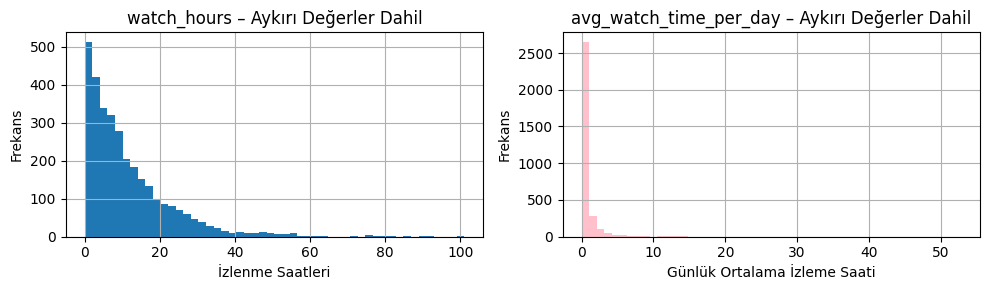

In [403]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.hist(new_train_df['watch_hours'], bins=50)
plt.title("watch_hours – Aykırı Değerler Dahil")
plt.xlabel("İzlenme Saatleri")
plt.ylabel("Frekans")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(new_train_df['avg_watch_time_per_day'], bins=50, color= "pink")
plt.title("avg_watch_time_per_day – Aykırı Değerler Dahil")
plt.xlabel("Günlük Ortalama İzleme Saati")
plt.ylabel("Frekans")
plt.grid(True)

plt.tight_layout()
plt.show()

Aykırı değer çıkan değişkenleri grafiklerle de incelediğimizde, verinin yapısını olumsuz etkiledikleri görülmektedir. Örneğin **avg_watch_time_per_day** değişkeninin değerinin 50'nin üzerinde olması, bu değerlerin yanlış girildiğini göstermektedir. Bu nedenle aykırı değerler alt ve üst sınırlar içine çekmek anlamına gelen **Winsorize** yöntemiyle elimine edilmiştir. Bu yöntemle veri kaybı da önlenmiş olmaktadır. Bu işlemlerin daha sonra validation ve test veri setlerine de uygulanabilmesi amacıyla winsorize işlemi bir fonksiyon haline getirilmiş ve daha sonra new_train veri setine uygulanmıştır.

In [404]:
def winsorize(x, col):
    q1 = x[col].quantile(0.25)
    q3 = x[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    x[col] = x[col].clip(lower_bound, upper_bound)

In [405]:
winsorize(new_train_df, "watch_hours")
winsorize(new_train_df, "avg_watch_time_per_day")

Aykırı değerler sınırların içine çekildikten sonra grfikler daha dengeli bir dağılım göstermiştir:

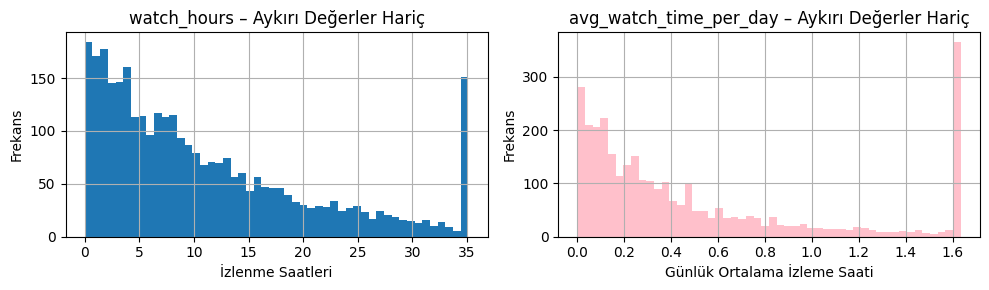

In [406]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.hist(new_train_df['watch_hours'], bins=50)
plt.title("watch_hours – Aykırı Değerler Hariç")
plt.xlabel("İzlenme Saatleri")
plt.ylabel("Frekans")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(new_train_df['avg_watch_time_per_day'], bins=50, color = "pink")
plt.title("avg_watch_time_per_day – Aykırı Değerler Hariç")
plt.xlabel("Günlük Ortalama İzleme Saati")
plt.ylabel("Frekans")
plt.grid(True)

plt.tight_layout()
plt.show()

#**5. Validation ve Test Veri Setlerinin Hazırlanması**

In [407]:
url = "https://raw.githubusercontent.com/dsoztorun/veri_bilimi_projesi/refs/heads/main/ncc_validation.csv"
validation_df1 = pd.read_csv(url)
validation_df = validation_df1.copy()

In [408]:
url = "https://raw.githubusercontent.com/dsoztorun/veri_bilimi_projesi/refs/heads/main/ncc_test.csv"
test_df1 = pd.read_csv(url)
test_df = test_df1.copy()

Eksik değer analiziyle, eksik değerin olmadığı tespit edilmiştir.

In [409]:
validation_df.isnull().sum().sum()

np.int64(0)

In [410]:
test_df.isnull().sum().sum()

np.int64(0)

"Object" tipindeki sütunlar kategorize edilmiş, ardından kategorik değerler kalıcı olarak numerik hale getirilmiştir:

In [411]:
train_ctgs(validation_df)
train_ctgs(test_df)

In [412]:
for col in validation_df.select_dtypes(["category"]).columns:
    validation_df[col] = validation_df[col].cat.codes

In [413]:
for col in test_df.select_dtypes(["category"]).columns:
    test_df[col] = test_df[col].cat.codes

Veri setlerinde aykırı değer olup olmadığı kontrol edilmiştir:

In [414]:
numeric_cols = ['age', 'watch_hours', 'last_login_days', 'monthly_fee', 'avg_watch_time_per_day']

for i in numeric_cols:
    aralik = validation_df[i].quantile(0.75) - validation_df[i].quantile(0.25)
    alt_sinir = validation_df[i].quantile(0.25) - 1.5 * aralik
    ust_sinir = validation_df[i].quantile(0.75) + 1.5 * aralik
    aykiri = validation_df[(validation_df[i] < alt_sinir) | (validation_df[i] > ust_sinir)]

    if len(aykiri) != 0:
        print(f"{i}: {len(aykiri)} adet aykırı değer tespit edildi")
    else:
        continue

watch_hours: 38 adet aykırı değer tespit edildi
avg_watch_time_per_day: 71 adet aykırı değer tespit edildi


In [415]:
numeric_cols = ['age', 'watch_hours', 'last_login_days', 'monthly_fee', 'avg_watch_time_per_day']

for i in numeric_cols:
    aralik = test_df[i].quantile(0.75) - test_df[i].quantile(0.25)
    alt_sinir = test_df[i].quantile(0.25) - 1.5 * aralik
    ust_sinir = test_df[i].quantile(0.75) + 1.5 * aralik
    aykiri = test_df[(test_df[i] < alt_sinir) | (test_df[i] > ust_sinir)]

    if len(aykiri) != 0:
        print(f"{i}: {len(aykiri)} adet aykırı değer tespit edildi")
    else:
        continue

watch_hours: 60 adet aykırı değer tespit edildi
avg_watch_time_per_day: 122 adet aykırı değer tespit edildi


Aykırı değerlerin bulunduğu değişkenler grafikleştirilmiştir:

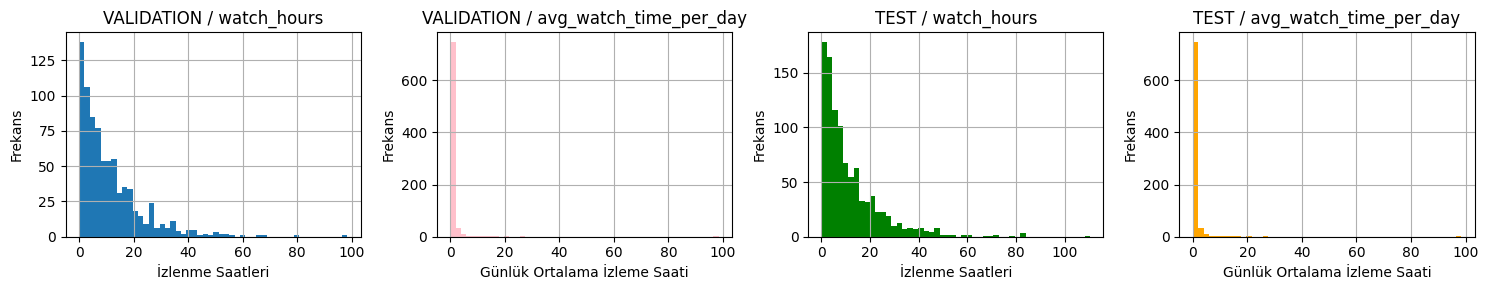

In [416]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 4, 1)
plt.hist(validation_df['watch_hours'], bins=50)
plt.title("VALIDATION / watch_hours")
plt.xlabel("İzlenme Saatleri")
plt.ylabel("Frekans")
plt.grid(True)

plt.subplot(1, 4, 2)
plt.hist(validation_df['avg_watch_time_per_day'], bins=50, color= "pink")
plt.title("VALIDATION / avg_watch_time_per_day")
plt.xlabel("Günlük Ortalama İzleme Saati")
plt.ylabel("Frekans")
plt.grid(True)

plt.subplot(1, 4, 3)
plt.hist(test_df['watch_hours'], bins=50, color="green")
plt.title("TEST / watch_hours")
plt.xlabel("İzlenme Saatleri")
plt.ylabel("Frekans")
plt.grid(True)

plt.subplot(1, 4, 4)
plt.hist(validation_df['avg_watch_time_per_day'], bins=50, color= "orange")
plt.title("TEST / avg_watch_time_per_day")
plt.xlabel("Günlük Ortalama İzleme Saati")
plt.ylabel("Frekans")
plt.grid(True)

plt.tight_layout()
plt.show()

Her iki sette de bulunan aykırı değerler **winsorize** yöntemiyle sınır değerler arasına çekilmiş ve ardından grafikleştirilmiştir:

In [417]:
winsorize(validation_df, "watch_hours")
winsorize(validation_df, "avg_watch_time_per_day")

winsorize(test_df, "watch_hours")
winsorize(test_df, "avg_watch_time_per_day")

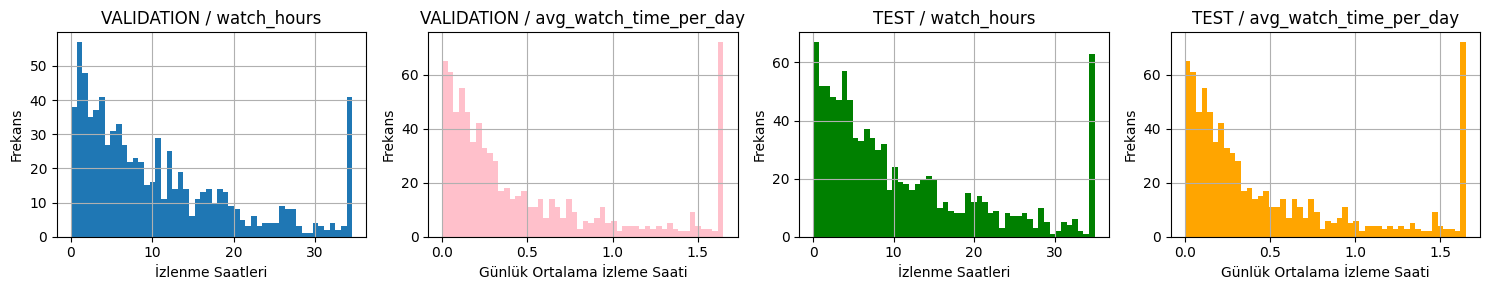

In [418]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 4, 1)
plt.hist(validation_df['watch_hours'], bins=50)
plt.title("VALIDATION / watch_hours")
plt.xlabel("İzlenme Saatleri")
plt.ylabel("Frekans")
plt.grid(True)

plt.subplot(1, 4, 2)
plt.hist(validation_df['avg_watch_time_per_day'], bins=50, color= "pink")
plt.title("VALIDATION / avg_watch_time_per_day")
plt.xlabel("Günlük Ortalama İzleme Saati")
plt.ylabel("Frekans")
plt.grid(True)

plt.subplot(1, 4, 3)
plt.hist(test_df['watch_hours'], bins=50, color="green")
plt.title("TEST / watch_hours")
plt.xlabel("İzlenme Saatleri")
plt.ylabel("Frekans")
plt.grid(True)

plt.subplot(1, 4, 4)
plt.hist(validation_df['avg_watch_time_per_day'], bins=50, color= "orange")
plt.title("TEST / avg_watch_time_per_day")
plt.xlabel("Günlük Ortalama İzleme Saati")
plt.ylabel("Frekans")
plt.grid(True)

plt.tight_layout()
plt.show()

#**6. Modelleme:**

Hedef değişken "churned" olarak belirlendiğinden, kullanılacak sütunlar söz konusu değişken göz önüne alınarak ayrılmıştır. X_train "churned" hariç tüm sütunları, y_train ise "churned" sütununu göstermektedir. Ardından **RandomForestClassifier** metoduyla modelleme gerçekleştirilmiştir:

In [419]:
X_train = new_train_df.drop("churned", axis=1)
y_train = new_train_df["churned"]

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Modeli eğitilmiş olduğundan, validation seti ile tahmin yapıp modeli değerlendirmeye geçilmiştir:

In [420]:
X_val = validation_df.drop("churned", axis=1)
y_val = validation_df["churned"]

validation_predictions = rf_model.predict(X_val)

In [421]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:\n", confusion_matrix(y_val, validation_predictions))
print("\nClassification Report:\n", classification_report(y_val, validation_predictions))

Confusion Matrix:
 [[379  19]
 [ 20 382]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       398
           1       0.95      0.95      0.95       402

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



**Model Değerlendirme – Validation Seti**

RandomForestClassifier modeli, validation veri seti üzerinde test edildiğinde oldukça başarılı bir performans sergilemiştir. Aşağıdaki öne çıkan sonuçlar dikkat çekmektedir:

- **Doğruluk (Accuracy):** %95  
- **Precision:** Her iki sınıf için de %95 — modelin pozitif ve negatif tahminleri isabetlidir.  
- **Recall:** %95 — model, hem churn eden (kaybedilen) hem de etmeyen (kaybedilmeyen) kullanıcıları yüksek oranda doğru tespit etmiştir.  
- **F1-Skoru:** %95 — precision ve recall dengesinin oldukça iyi olduğunu gösterir.

**Confusion Matrix** incelendiğinde:
- Model, 398 churn etmeyen (kaybedilmeyen) müşteriden 379’unu doğru tahmin etmiş, sadece 19’unu yanlış sınıflandırmıştır.
- Aynı şekilde churn eden (kaybedilen) 402 müşteriden 382’si doğru tahmin edilmiş, 20’si hatalı sınıflandırılmıştır.

Bu sonuçlar, modelin hem **churn eden (kaybedilen) hem de etmeyen (kaybedilmeyen) kullanıcıları** yüksek doğrulukla ayırt edebildiğini ve aşırı uydurma (overfitting) belirtileri göstermediğini düşündürmektedir. Sonraki aşamadan modelin gerçek dünyadaki performansını görmek için test seti ile değerlendirme yapılmıştır:

In [422]:
X_test = test_df.drop("churned", axis=1)
y_test = test_df["churned"]

test_predictions = rf_model.predict(X_test)

print("Confusion Matrix (Test Seti):\n", confusion_matrix(y_test, test_predictions))
print("\nClassification Report (Test Seti):\n", classification_report(y_test, test_predictions))

Confusion Matrix (Test Seti):
 [[477  20]
 [ 19 484]]

Classification Report (Test Seti):
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       497
           1       0.96      0.96      0.96       503

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



** Test Seti Performans Değerlendirmesi**

Test veri seti ile yapılan değerlendirme sonuçlarına göre modelin genel başarımı oldukça yüksektir:

**Confusion Matrix:**
```
              Gerçek
              0     1
Tahmin   0   477    20
         1    19   484
```

**Sınıflandırma Raporu:**
- **Doğruluk (Accuracy):** `0.96`
- **Precision (Kesinlik):**
  - Sınıf 0 için: `0.96`
  - Sınıf 1 için: `0.96`
- **Recall (Duyarlılık):**
  - Sınıf 0 için: `0.96`
  - Sınıf 1 için: `0.96`
- **F1-Skoru:**
  - Her iki sınıf için de `0.96`

**Yorum:**
- Model, **her iki sınıfı da oldukça dengeli ve başarılı** bir şekilde tahmin etmiştir.
- Sınıf dengesine dikkat edildiğinde hem churn(kaybedilen) (1) hem de churn olmayan(kaybedilmeyen) (0) kullanıcıları %96 doğrulukla tahmin etmiştir.
- Bu sonuçlar, modelin **genelleme gücünün yüksek** olduğunu ve **validation setindeki başarıyı test setinde de koruduğunu** göstermektedir.

***Bütün modelleme çalışmasından çıkarılan genel sonuç ise, bu veri setinde yer alan değişkenlerin birlikte kullanıldığında müşteri kaybı yaşanıp yaşanmayacağı konusunda tahmin yapmak için yeterince anlamlı bilgiler içerdiğidir.***